In [35]:
import sys
sys.path.append("../..")

In [36]:
import matplotlib.pyplot as plt

In [37]:
%matplotlib inline

In [38]:
import scipy, GPy, os,ast
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from gp_growth.storage import mongo
db = mongo.MongoDB()

from gp_growth import factory, testStatistic, normal
from gp_growth.categorical import Categorical
from gp_growth import metric
from gp_growth.data import filter, growth
from gp_growth.storage import searcher

In [39]:
import numpy as np

In [40]:
db = mongo.MongoDB()

In [41]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'blue'),
                                                    (.05, 'white'),
                                                    (.95, 'white'),
                                                    (1, 'red')]
                                        )

In [42]:
reload(testStatistic)

<module 'gp_growth.testStatistic' from '../../gp_growth/testStatistic.pyc'>

In [43]:
def gpParams(gp):
    ret = {}

    for p in gp.kern.parameters:
        if p.param_array.shape[0] > 1:
    #         print p
            n = p.parameter_names()[0]
            for i in range(p.param_array.shape[0]):
                ret[gp.kern.name+"_"+n+"_"+str(i)] = p.param_array[i]
        else:
            ret[gp.kern.name+"_"+p.parameter_names()[0]] = p[0]
    #         print p
    #         ret[p.name] = p[0]

    for p in gp.likelihood.parameters:
        # need to go deeper
        if isinstance(p,GPy.likelihoods.likelihood.Likelihood):
            for t in p.parameters:
                for ind,n in enumerate(t.parameter_names()):
                    # param_names.append("_".join([gp.likelihood.name,n]))
                    # params.append(p.values[ind])
                    ret["_".join([gp.likelihood.name,p.name,n])] = t.values[ind]
        else:
            for ind,n in enumerate(p.parameter_names()):
                # param_names.append("_".join([gp.likelihood.name,n]))
                # params.append(p.values[ind])
                ret["_".join([gp.likelihood.name,n])] = p.values[ind]

    return ret

In [44]:
colors = sns.hls_palette(n_colors=10,l=.5)
wtColor = 'k'
mutantColor = colors[4]
m1color = colors[-2]#'k'
m2color = colors[3]

colors = sns.color_palette("BuGn_r")
c1 = colors[1]
c2 = colors[2]
mutantColor=c1

# Plot data 

In [45]:
plates = [u'20150715 PQ 8',
 u'20150607 PQ 4',
 u'20150630 PQ 5',
 u'20150717 PQ 9',
 u'20150514 PQ 2',
 u'20150702 PQ 6',
 u'20150704 PQ 7']

In [11]:
for p in plates:
    strains = db.getExperimentalDesigns("Strain",plate=p)
    for s in strains:
        
        if s == "ura3" or s == "blank":
            continue
            
        print s,p
        
        data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':[0,.333]})
        data.data = data.data.iloc[4:,:]
        data.data.time = data.data.time - data.data.time.values[0]
        data.poly_scale(5,10,groupby=["Strain","mM PQ"])
        
        fig,ax = plt.subplots(figsize=(16,6))
        ylim = (data.data.iloc[:,1:].min().min(),data.data.iloc[:,1:].max().max())
        data.key = data.key.sort("Strain",ascending=s < "ura3")
        data.data.iloc[:,1:] = data.data.iloc[:,data.key.index]
        data.plot(groupby=['mM PQ'],colorby="Strain",newFig=False,title_index=[],colors=[mutantColor,'k'],legend_kwargs={"fontsize":15})
        
        plt.subplot(121)
        plt.ylabel("log(OD)",fontsize=35)
        plt.yticks(fontsize=30)
        plt.xlabel("time (h)",fontsize=35)
        plt.xticks(fontsize=30)
        
        plt.subplot(122)
        plt.yticks(fontsize=30)
        plt.xlabel("time (h)",fontsize=35)
        plt.xticks(fontsize=30)
        
        plt.suptitle("Growth data",fontsize=35)
        
        plt.tight_layout(pad=4)
        
        plt.savefig("figures/data/%s_%s.png"%(s,p),bbox_inches="tight")
        plt.close()


VNG2268 20150715 PQ 8
VNG1179 20150715 PQ 8
trmB 20150715 PQ 8
VNG2614 20150715 PQ 8
VNG0194H 20150607 PQ 4
hlx2 20150607 PQ 4
hrg 20150607 PQ 4
rosR 20150607 PQ 4
sirR 20150630 PQ 5
idr1 20150630 PQ 5
troR 20150630 PQ 5
idr2 20150630 PQ 5
phoR 20150717 PQ 9
VNG0195 20150717 PQ 9
ark 20150717 PQ 9
kinA2 20150717 PQ 9
phoU 20150514 PQ 2
VNG1179 20150514 PQ 2
cspD2 20150514 PQ 2
cspD1 20150514 PQ 2
arcR 20150702 PQ 6
birA 20150702 PQ 6
hlx1 20150702 PQ 6
kaiC 20150702 PQ 6
VNG0471 20150704 PQ 7
VNG1029 20150704 PQ 7
prp2 20150704 PQ 7
VNG0039 20150704 PQ 7


# Paraquat stress 

In [ ]:
plates = [u'20150715 PQ 8',
 u'20150607 PQ 4',
 u'20150630 PQ 5',
 u'20150514 PQ 2',
 u'20150517 PQ 3']

In [66]:
#strains = ['sirR','idr1','idr2','rosR','trmB','VNG1179']
strains = ['ura3','sirR','idr1','idr2','rosR','trmB','VNG1179','asnC']

In [67]:
# plates = [db.plates.find_one(db.getExperimentalDesigns("plate",Strain=s,plate=plates)[0])['name'] for s in strains]
# plates

plates = [[db.plates.find_one(p)['name'] for p in db.getExperimentalDesigns("plate",Strain=s,plate=plates)] for s in strains]
plates

[[u'20150715 PQ 8', u'20150607 PQ 4', u'20150630 PQ 5'],
 [u'20150630 PQ 5'],
 [u'20150630 PQ 5'],
 [u'20150630 PQ 5'],
 [u'20150607 PQ 4'],
 [u'20150715 PQ 8'],
 [u'20150715 PQ 8'],
 []]

In [43]:
# conf = []
# intConf = []
# labels = []
# bfs = []
# gp_params = pd.DataFrame()
# gp_null_params = pd.DataFrame()

# for p in plates:
#     strains = db.getExperimentalDesigns("Strain",plate=p)
#     for s in strains:
        
#         if s == "ura3" or s == "blank":
#             continue
        
#         labels.append((s,p))
        
#         data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':[0,.333]})
#         data.data = data.data.iloc[4:,:]
#         data.data.time = data.data.time - data.data.time.values[0]
#         data.poly_scale(5,10,groupby=["Strain","mM PQ"])
        
#         # add mutant x pq dimension
#         data.key['MutantStress'] = (data.key.Strain != "ura3") * data.key['mM PQ'] == .333        
        
#         ts = testStatistic.TestStatistic(growth.GrowthData(data.data.copy(),data.key.copy()),
#                                          ['mM PQ','MutantStress'],
#                                          normalize=True)
#         ts_null = testStatistic.TestStatistic(growth.GrowthData(data.data.copy(),data.key.copy()),
#                                               ['mM PQ'],normalize=True)
        
        
#         bfs.append(ts.buildGP(thin=12).log_likelihood()-ts_null.buildGP(thin=12).log_likelihood())
                
#         gp_params = gp_params.append(pd.DataFrame(gpParams(ts.buildGP()),index=[s]))
#         gp_null_params = gp_null_params.append(pd.DataFrame(gpParams(ts_null.buildGP()),index=[s]))
        
#         print s,p, bfs[-1]

#         t = np.linspace(5,48)
#         ms = np.zeros((2*t.shape[0],))
#         ms[t.shape[0]:,] = 1 
        
# #         t = (t-fact.means['time'])/fact.std['time']
# #         ms = (ms-fact.means['MutantStress'])/fact.std['MutantStress']
        
#         # this corrects for mutant stress response difference
# #         diff = ts.computeFullDifference(t,Strain=(0-fact.means['Strain'])/fact.std['Strain'],MutantStress=ms,**{'mM PQ':(.333-fact.means['mM PQ'])/fact.std['mM PQ']})
# #         diff = diff.dot(np.diag(np.ones(diff.n))*ts.std)
#         diff = ts.computeFullDifference(t,Strain=0,MutantStress=ms,**{'mM PQ':.333})
                                        
#         diff.plot(t[1:])
#         plt.plot([t.min(),t.max()],[0,0],'k',linewidth=3)
#         plt.xlabel("time (h)",fontsize=30)
#         plt.xticks(fontsize=25)
#         plt.ylabel("$OD_m - OD_p$",fontsize=30)
#         plt.yticks(fontsize=25)
#         plt.title("Function Difference",fontsize=30)
#         plt.savefig("figures/functionDiff_pq_"+s+"_"+p+".png",bbox_inches="tight")
#         plt.close()
        
# #         conf.append(ts.computeFullConfidence(t,
# #                                              Strain=(0-fact.means['Strain'])/fact.std['Strain'],
# #                                              MutantStress=ms,
# #                                              **{'mM PQ':(.333-fact.means['mM PQ'])/fact.std['mM PQ']}))
#         conf.append(ts.computeFullConfidence(t,
#                                              Strain=0,
#                                              MutantStress=ms,
#                                              **{'mM PQ':.333}))
    
#         parent = ts.predict(t,
#                             Strain=1,
#                             MutantStress=0,
#                             function=True,
#                             **{'mM PQ':.333})
#         mutant_noInteraction = ts.predict(t,
#                                           Strain=0,
#                                           MutantStress=0,
#                                           function=True,
#                                           **{'mM PQ':.333})
#         mutant = ts.predict(t,
#                             Strain=0,
#                             MutantStress=1,
#                             function=True,
#                             **{'mM PQ':.333})
        
        
#         parent.plot(color=wtColor,label="$OD_p$",alpha=.4)
#         mutant_noInteraction.plot(color=m1color,label="$OD_m($Strain x mM PQ$ = 0)$",alpha=.4)
#         mutant.plot(color=mutantColor,label="$OD_m$",alpha=.4)
#         plt.xlabel("time (h)",fontsize=30)
#         plt.xticks(fontsize=25)
#         plt.ylabel("$OD$",fontsize=30)
#         plt.yticks(fontsize=25)
#         plt.legend(loc="best",fontsize=25)
#         plt.title("Growth Prediction",fontsize=30)
#         plt.savefig("figures/growthPrediction_pq_"+s+"_"+p+".png",bbox_inches="tight")
#         plt.close()
        
# conf = np.array(conf)
# intConf = np.array(intConf)
# bfs = np.array(bfs)
# labels = pd.DataFrame(labels,columns=['Strain','plate'])

VNG2268 20150715 PQ 8 -2.61860856199e-06
VNG1179 20150715 PQ 8 0.207345361975
trmB 20150715 PQ 8 -9.83657400866e-07
VNG2614 20150715 PQ 8 -8.84513809751e-07
VNG0194H 20150607 PQ 4 -1.44588020135e-06
hlx2 20150607 PQ 4 1.4437138463
hrg 20150607 PQ 4 4.29413833846
rosR 20150607 PQ 4 -1.25784731608e-06
sirR 20150630 PQ 5 0.63465479055
idr1 20150630 PQ 5 0.226784590368
troR 20150630 PQ 5 -1.50309949731e-06
idr2 20150630 PQ 5 -6.26518385616e-07
phoR 20150717 PQ 9 0.0230423746631
1.5515447011e-06
1.5515447011e-05
0.00015515447011
0.0015515447011
0.015515447011
VNG0195 20150717 PQ 9 -1.00164540189
ark 20150717 PQ 9 0.150672264375
kinA2 20150717 PQ 9 1.09168159095
phoU 20150514 PQ 2 1.64163070167
VNG1179 20150514 PQ 2 0.0933001886645
cspD2 20150514 PQ 2 4.59661635722
cspD1 20150514 PQ 2 0.129843947547
arcR 20150702 PQ 6 3.68270043022
birA 20150702 PQ 6 0.270429783387
hlx1 20150702 PQ 6 0.00056117736159
kaiC 20150702 PQ 6 -3.45779056943e-07
VNG0471 20150704 PQ 7 0.116969520482
VNG1029 20150704 

In [21]:
zip(plates,strains)

[(u'20150630 PQ 5', 'sirR'),
 (u'20150630 PQ 5', 'idr1'),
 (u'20150630 PQ 5', 'idr2'),
 (u'20150607 PQ 4', 'rosR'),
 (u'20150715 PQ 8', 'trmB'),
 (u'20150514 PQ 2', 'VNG1179')]

In [29]:
conf = []
intConf = []
labels = []
bfs = []
gp_params = pd.DataFrame()
gp_null_params = pd.DataFrame()

for p,s in zip(plates,strains):
    
    print s,p
        
    data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':[0,.333]})
    data.data = data.data.iloc[4:,:]
    data.data.time = data.data.time - data.data.time.values[0]
    data.poly_scale(5,10,groupby=["Strain","mM PQ"])

    # add mutant x pq dimension
    data.key['MutantStress'] = (data.key.Strain != "ura3") * data.key['mM PQ'] == .333        

    ts = testStatistic.TestStatistic(growth.GrowthData(data.data.copy(),data.key.copy()),
                                     ['mM PQ','MutantStress'],
                                     normalize=True)
    ts_null = testStatistic.TestStatistic(growth.GrowthData(data.data.copy(),data.key.copy()),
                                          ['mM PQ'],normalize=True)


    bfs.append(ts.buildGP(thin=12).log_likelihood()-ts_null.buildGP(thin=12).log_likelihood())
    labels.append((s,p))

    gp_params = gp_params.append(pd.DataFrame(gpParams(ts.buildGP()),index=[s]))
    gp_null_params = gp_null_params.append(pd.DataFrame(gpParams(ts_null.buildGP()),index=[s]))

    print s,p, bfs[-1]

    t = np.linspace(5,48)
    ms = np.zeros((2*t.shape[0],))
    ms[t.shape[0]:,] = 1 

#         t = (t-fact.means['time'])/fact.std['time']
#         ms = (ms-fact.means['MutantStress'])/fact.std['MutantStress']

    # this corrects for mutant stress response difference
#         diff = ts.computeFullDifference(t,Strain=(0-fact.means['Strain'])/fact.std['Strain'],MutantStress=ms,**{'mM PQ':(.333-fact.means['mM PQ'])/fact.std['mM PQ']})
#         diff = diff.dot(np.diag(np.ones(diff.n))*ts.std)
    diff = ts.computeFullDifference(t,Strain=0,MutantStress=ms,**{'mM PQ':.333})

    diff.plot(t[1:])
    plt.plot([t.min(),t.max()],[0,0],'k',linewidth=3)
    plt.xlabel("time (h)",fontsize=35)
    plt.xticks(fontsize=30)
    plt.ylabel("$OD_m - OD_p$",fontsize=35)
    plt.yticks(fontsize=30)
    plt.title("Function Difference",fontsize=35)
    plt.savefig("figures/functionDiff_pq_"+s+"_"+p+".png",bbox_inches="tight")
    plt.close()

    conf.append(ts.computeFullConfidence(t,
                                         Strain=0,
                                         MutantStress=ms,
                                         **{'mM PQ':.333}))
    
    ######################################

#     parent = ts.predict(t,
#                         Strain=1,
#                         MutantStress=0,
#                         function=True,
#                         **{'mM PQ':.333})
#     mutant_noInteraction = ts.predict(t,
#                                       Strain=0,
#                                       MutantStress=0,
#                                       function=True,
#                                       **{'mM PQ':.333})
#     mutant = ts.predict(t,
#                         Strain=0,
#                         MutantStress=1,
#                         function=True,
#                         **{'mM PQ':.333})


#     parent.plot(color=wtColor,label="$OD_p$",alpha=.4)
#     mutant_noInteraction.plot(color='red',label="$OD_m($Strain x mM PQ$ = 0)$",alpha=.4)
#     mutant.plot(color=mutantColor,label="$OD_m$",alpha=.4)
#     plt.xlabel("time (h)",fontsize=35)
#     plt.xticks(fontsize=30)
#     plt.ylabel("$OD$",fontsize=35)
#     plt.yticks(fontsize=30)
#     plt.legend(loc="best",fontsize=30)
#     plt.title("Growth Prediction",fontsize=35)
#     plt.savefig("figures/growthPrediction_pq_"+s+"_"+p+".png",bbox_inches="tight")
#     plt.close()
    
    ##########################################
    
    plt.figure(figsize=(16,8))
    t = np.linspace(0,48)
    
    data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':[0,.333]})
    #data.data = data.data.loc[:96,:] # remove extra time samples
    data.data = data.data.iloc[4:,:]
    data.data.time = data.data.time - data.data.time.values[0]
    data.poly_scale(5,10,groupby=["Strain","mM PQ"])
    
    plt.subplot(121)
    plt.plot(data.data.time,data.data.loc[:,data.key.index[np.all((data.key.Strain=='ura3',data.key['mM PQ']==0),0)]],c='k',alpha=.4)
    plt.plot(data.data.time,data.data.loc[:,data.key.index[np.all((data.key.Strain=='ura3',data.key['mM PQ']!=0),0)]],c=mutantColor,alpha=.4)
    parent = ts.predict(t,
                        Strain=1,
                        MutantStress=0,
                        function=False,
                        **{'mM PQ':0})
    parent.plot(t,color='k',alpha=.2,label='0 mM PQ')
    
    parent = ts.predict(t,
                        Strain=1,
                        MutantStress=0,
                        function=False,
                        **{'mM PQ':0.333})
    parent.plot(t,color=mutantColor,alpha=.2,label='0.333 mM PQ')
    plt.xlabel("time (h)",fontsize=35)
    plt.xticks(fontsize=30)
    plt.ylabel("log(OD)",fontsize=35)
    plt.yticks(fontsize=30)
    plt.legend(loc="best",fontsize=25)
    plt.title("$\Delta ura3$",fontsize=40)
    plt.xlim(-2,50)
    
    plt.subplot(122)
    plt.plot(data.data.time,data.data.loc[:,data.key.index[np.all((data.key.Strain!='ura3',data.key['mM PQ']==0),0)]],c='k',alpha=.4)
    plt.plot(data.data.time,data.data.loc[:,data.key.index[np.all((data.key.Strain!='ura3',data.key['mM PQ']!=0),0)]],c=mutantColor,alpha=.4)
    mutant_noInteraction = ts.predict(t,
                                      Strain=0,
                                      MutantStress=0,
                                      function=False,
                                      **{'mM PQ':.333})
    mutant = ts.predict(t,
                        Strain=0,
                        MutantStress=1,
                        function=False,
                        **{'mM PQ':.333})

    mutant_noInteraction.plot(t,color=m1color,label="no interaction\n(Strain x mM PQ = 0)",alpha=.4)
    mutant.plot(t,color=mutantColor,alpha=.4)
    
    mutant = ts.predict(t,
                        Strain=0,
                        MutantStress=0,
                        function=False,
                        **{'mM PQ':0})
    mutant.plot(t,color='k',alpha=.4)
    plt.xlim(-2,50)
    
    plt.xlabel("time (h)",fontsize=35)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="best",fontsize=25)
    plt.title("$\Delta %s$"%s,fontsize=40)
    plt.savefig("figures/growthPrediction_pq_"+s+".png",bbox_inches="tight",dpi=300)
    plt.close()
    
        
conf = np.array(conf)
intConf = np.array(intConf)
bfs = np.array(bfs)
labels = pd.DataFrame(labels,columns=['Strain','plate'])

sirR 20150630 PQ 5
sirR 20150630 PQ 5 0.634654795607
idr1 20150630 PQ 5
idr1 20150630 PQ 5 0.226784590369
idr2 20150630 PQ 5
idr2 20150630 PQ 5 -3.65831624549e-07
rosR 20150607 PQ 4
rosR 20150607 PQ 4 -3.73934824438e-07
trmB 20150715 PQ 8
trmB 20150715 PQ 8 -3.31466844727e-06
VNG1179 20150715 PQ 8
VNG1179 20150715 PQ 8 0.207345361741


In [25]:
gp_params.to_csv("pq_gpParams.csv")
gp_null_params.to_csv("pq_gpParams_null.csv")

In [24]:
bak = conf.copy()
conf[np.isnan(conf)] = .5

# thresh = np.any((conf > .95,conf < .05),0)*conf
thresh = np.where(conf < .05,-1,np.where(conf>.95,1,0))

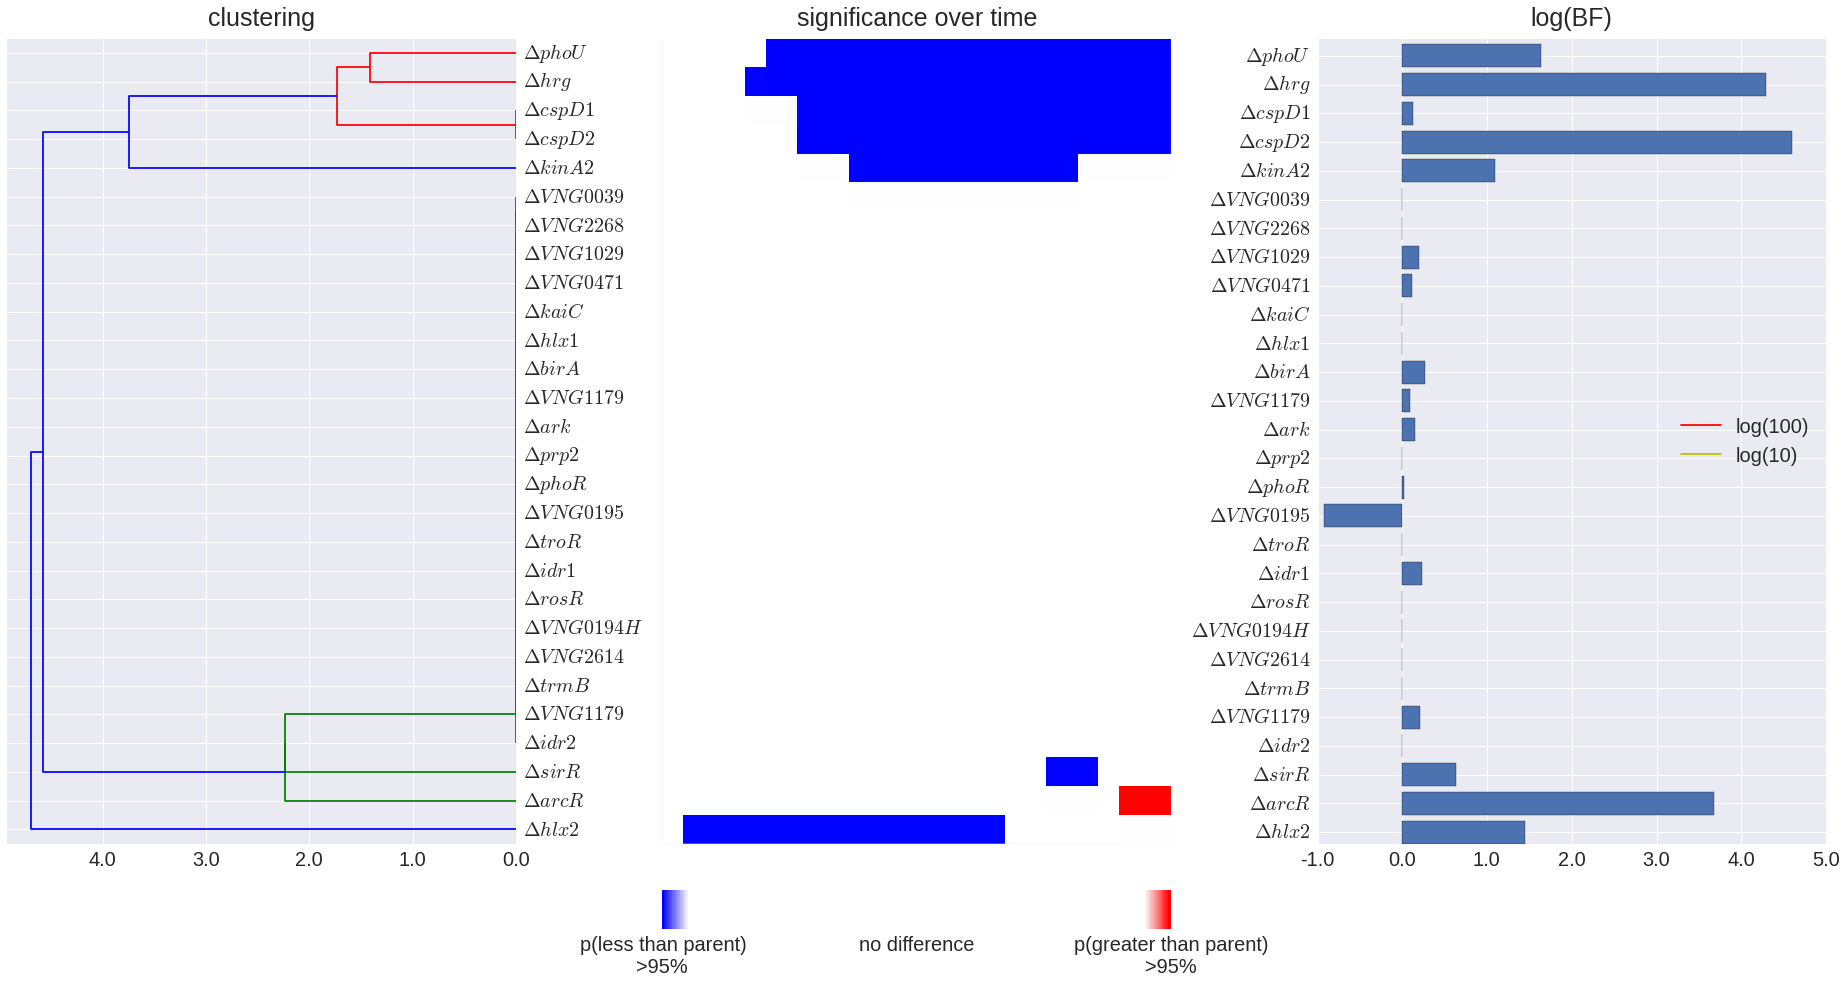

In [245]:
plt.figure(figsize=(26,14))
aspect = 10

ax1 = plt.subplot2grid((aspect+1,3), (0,0), colspan=1, rowspan=aspect)
ax2 = plt.subplot2grid((aspect+1,3), (0,1), colspan=1, rowspan=aspect)
# ax3 = plt.subplot2grid((aspect+1,4), (0,2), colspan=1, rowspan=aspect)
ax4 = plt.subplot2grid((aspect+1,3), (0,2), colspan=1, rowspan=aspect)
cbarAx = plt.subplot2grid((aspect+1,3), (aspect,1), colspan=1, rowspan=2)

# plt.subplot(131)
z = scipy.cluster.hierarchy.linkage(thresh)
ret = scipy.cluster.hierarchy.dendrogram(z,orientation="right",ax=ax1);
yt = ax1.get_yticks()
ax1.set_yticks(yt)
yl = ["$\Delta "+ l +'$' for l in labels.loc[ret['leaves'],"Strain"].tolist()]
ax1.set_yticklabels(yl,fontsize=20)
ax1.set_xticklabels(ax1.get_xticks().astype(str),fontsize=20)
ax1.set_title("clustering",fontsize=25,y=1.01)

# plt.subplot(132)
# im = ax2.imshow(1-conf[ret['leaves'],:],cmap=cmap,interpolation="none",aspect="auto",origin="top")
im = ax2.imshow(1-thresh[ret['leaves'],:],cmap=cmap,interpolation="none",aspect="auto",origin="top")
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("significance over time",fontsize=25,y=1.01)
# ax2.set_frame_on(True)

# cbar = plt.colorbar(im,ticks=[0,.5,1],orientation="horizontal",ax=cbarAx)
# cbar.ax.set_xticklabels(['less than parent', 'no difference', 'greater than parent'],fontsize=20)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbarAx, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',ticks=[0,.5,1])
cb1.ax.set_xticklabels(['p(less than parent)\n>95%', 'no difference', 'p(greater than parent)\n>95%'],fontsize=20)

# ax3.barh(range(intConf.shape[0]),1-intConf[ret['leaves']]-.5)
# ax3.plot([-.45,-.45],[0,intConf.shape[0]],'r')
# ax3.plot([.45,.45],[0,intConf.shape[0]],'r')

# ax3.set_ylim(0,intConf.shape[0])
# ax3.set_yticks(np.arange(intConf.shape[0])+.4)
# ax3.set_yticklabels(yl,fontsize=20)
# ax3.set_title("total significance",fontsize=25)

ax4.barh(range(bfs.shape[0]),bfs[ret['leaves']])
ax4.plot([np.log(100),np.log(100)],[0,intConf.shape[0]],'r',label="log(100)")
ax4.plot([np.log(10),np.log(10)],[0,intConf.shape[0]],'y',label="log(10)")
ax4.legend(loc="best",fontsize=20)

ax4.set_ylim(0,bfs.shape[0])
ax4.set_yticks(np.arange(bfs.shape[0])+.4)
ax4.set_yticklabels(yl,fontsize=20)
ax4.set_title("log(BF)",fontsize=25,y=1.01)
ax4.set_xticklabels(ax4.get_xticks().astype(str),fontsize=20)

plt.tight_layout(pad=2.0)
plt.savefig("figures/funcDiff_paraquat.png",bbox_inches="tight",dpi=300)

In [48]:
class MaternTS(testStatistic.TestStatistic):
    
    def buildKernel(self):
        return GPy.kern.Matern32(self.k,ARD=True)

In [54]:
bfsCompare = []

for p,s in zip(plates,strains):
    
    print s,p
    
    data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':[0,.333]})
    data.data = data.data.iloc[4:,:]
    data.data.time = data.data.time - data.data.time.values[0]
    data.poly_scale(5,10,groupby=["Strain","mM PQ"])

    # add mutant x pq dimension
    data.key['MutantStress'] = (data.key.Strain != "ura3") * data.key['mM PQ'] == .333        

    ts = testStatistic.TestStatistic(growth.GrowthData(data.data.copy(),data.key.copy()),
                                     ['mM PQ','MutantStress'],
                                     normalize=True)
    ts_null = testStatistic.TestStatistic(growth.GrowthData(data.data.copy(),data.key.copy()),
                                          ['mM PQ'],normalize=True)


    bfs1 = ts.buildGP().log_likelihood()-ts_null.buildGP().log_likelihood()
    
    ts = MaternTS(growth.GrowthData(data.data.copy(),data.key.copy()),
                                     ['mM PQ','MutantStress'],
                                     normalize=True)
    ts_null = MaternTS(growth.GrowthData(data.data.copy(),data.key.copy()),
                                          ['mM PQ'],normalize=True)
    #ts_null.inputDimensions = ['time']
    #ts_null.k = 1

    bfs2 = ts.buildGP().log_likelihood()-ts_null.buildGP().log_likelihood()
    
    bfsCompare.append((s,bfs1,bfs2))

sirR 20150630 PQ 5
idr1 20150630 PQ 5
idr2 20150630 PQ 5
rosR 20150607 PQ 4
trmB 20150715 PQ 8
VNG1179 20150715 PQ 8


In [61]:
bfsCompare = np.array(bfsCompare)

In [62]:
bfsCompare

array([['sirR', '0.690038921885', '-7.14532802675'],
       ['idr1', '0.189762259071', '0.451704231964'],
       ['idr2', '-5.17076034612e-06', '0.00152109741293'],
       ['rosR', '-3.7072699115e-06', '0.0362494778103'],
       ['trmB', '-4.33004117895e-07', '-2.21748291551e-06'],
       ['VNG1179', '0.0394685920024', '1.53884758207']], 
      dtype='|S18')

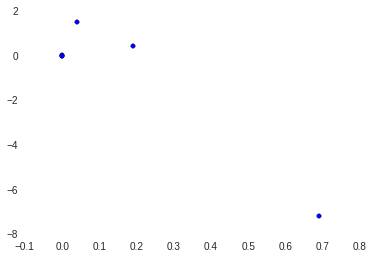

In [56]:
plt.scatter(bfsCompare[:,1],bfsCompare[:,2])

In [59]:
ts.gp

GP_regression.,value,constraints,priors
Mat32.variance,4.92706396023,+ve,
Mat32.lengthscale,"(4,)",+ve,
Gaussian_noise.variance,0.0344866087015,+ve,


In [60]:
ts_null.gp

GP_regression.,value,constraints,priors
Mat32.variance,12.4908500161,+ve,
Mat32.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,0.033880571009,+ve,


## Permutation correction

In [213]:
bfsPermuted = {}

Try permuting labels in a way that conserves # of samples at both PQ concentrations for each strain. e.g. only permute strain labels within a pq concentration

In [ ]:
t = np.linspace(5,48)
numPerm = 100

for p in plates:
    strains = db.getExperimentalDesigns("Strain",plate=p)
    for s in strains:
        if s == "ura3" or s == "blank":
            continue
        
        bfsPermuted[(s,p)] = []
        
        if (s,p) in bfsPermuted and len(bfsPermuted[(s,p)]) >= numPerm:
            continue
        
        data = db.getData(plate=p,Strain=["ura3",s],logged=True,**{'mM PQ':[0,.333]})
        data.data = data.data.iloc[4:,:]
        data.data.time = data.data.time - data.data.time.values[0]
        data.poly_scale(5,10,groupby=["Strain","mM PQ"])
        
        strainOrig = data.key.Strain.copy()
        
        orders = []
        
        for i in range(len(bfsPermuted[(s,p)]),numPerm):
        
            order = np.random.choice(range(data.key.shape[0]),data.key.shape[0],replace=False)
            orders.append(order)
            
            data.key.Strain = data.key.Strain[order].values
            data.key['MutantStress'] = (data.key.Strain != "ura3") * data.key['mM PQ'] == .333

            ts = testStatistic.TestStatistic(data,['mM PQ','MutantStress'],normalize=True)
            ts_null = testStatistic.TestStatistic(data,['mM PQ'],normalize=True)

            bfsPermuted[(s,p)].append(ts.buildGP(thin=12).log_likelihood()-ts_null.buildGP(thin=12).log_likelihood())
            
            data.key.Strain = strainOrig
            
        bfsPermuted[(s,p)] = np.array(bfsPermuted[(s,p)])
        print s,p,bfsPermuted[(s,p)].mean(),bfsPermuted[(s,p)].max(),bfsPermuted[(s,p)].std()
        

In [21]:
table = pd.read_csv("pq_bayesFactors.csv")

bfsPermuted = {}
for i,r in table.iterrows():
    bfsPermuted[(r.Strain,r.plate)] = np.array(ast.literal_eval(r.PermutedValues))

In [31]:
bfsPermuted

{('VNG1179',
  '20150715 PQ 8'): array([ -1.61496598e-06,  -7.02612749e-02,  -3.65919892e-01,
         -1.07854152e-06,  -1.30687888e-05,  -1.55991307e-06,
         -7.39017709e-03,   3.99371170e-02,   2.72521816e-01,
         -6.46635272e-07,   2.37488288e-06,   1.15034117e-05,
         -4.25807195e-06,   1.52409939e+00,   1.02539211e+00,
          1.21232035e+00,  -1.27916496e-06,   9.58569740e-02,
          7.16712866e-02,  -9.20818678e-07,  -7.08497538e-07,
         -9.00779699e-06,   5.48917576e-02,  -1.30045288e-05,
          5.59095022e-03,   7.47577610e-03,   3.46367978e-01,
         -8.80702487e-07,   8.38797141e-02,  -1.24641008e-06,
          1.68159951e-06,   2.59198259e-01,  -1.12711990e-06,
         -1.96552574e-06,   2.82615072e-01,   2.56501810e-01,
         -1.16045921e-05,  -8.62509381e-07,  -3.61361288e-08,
          3.57771548e-01,   6.65259599e-02,  -1.49195003e-06,
          2.99983958e-01,   1.53289820e+00,  -1.55847773e-01,
          1.70669585e-01,  -1.06393685

In [30]:
labels

,Strain,plate
0,sirR,20150630 PQ 5
1,idr1,20150630 PQ 5
2,idr2,20150630 PQ 5
3,rosR,20150607 PQ 4
4,trmB,20150715 PQ 8
5,VNG1179,20150715 PQ 8


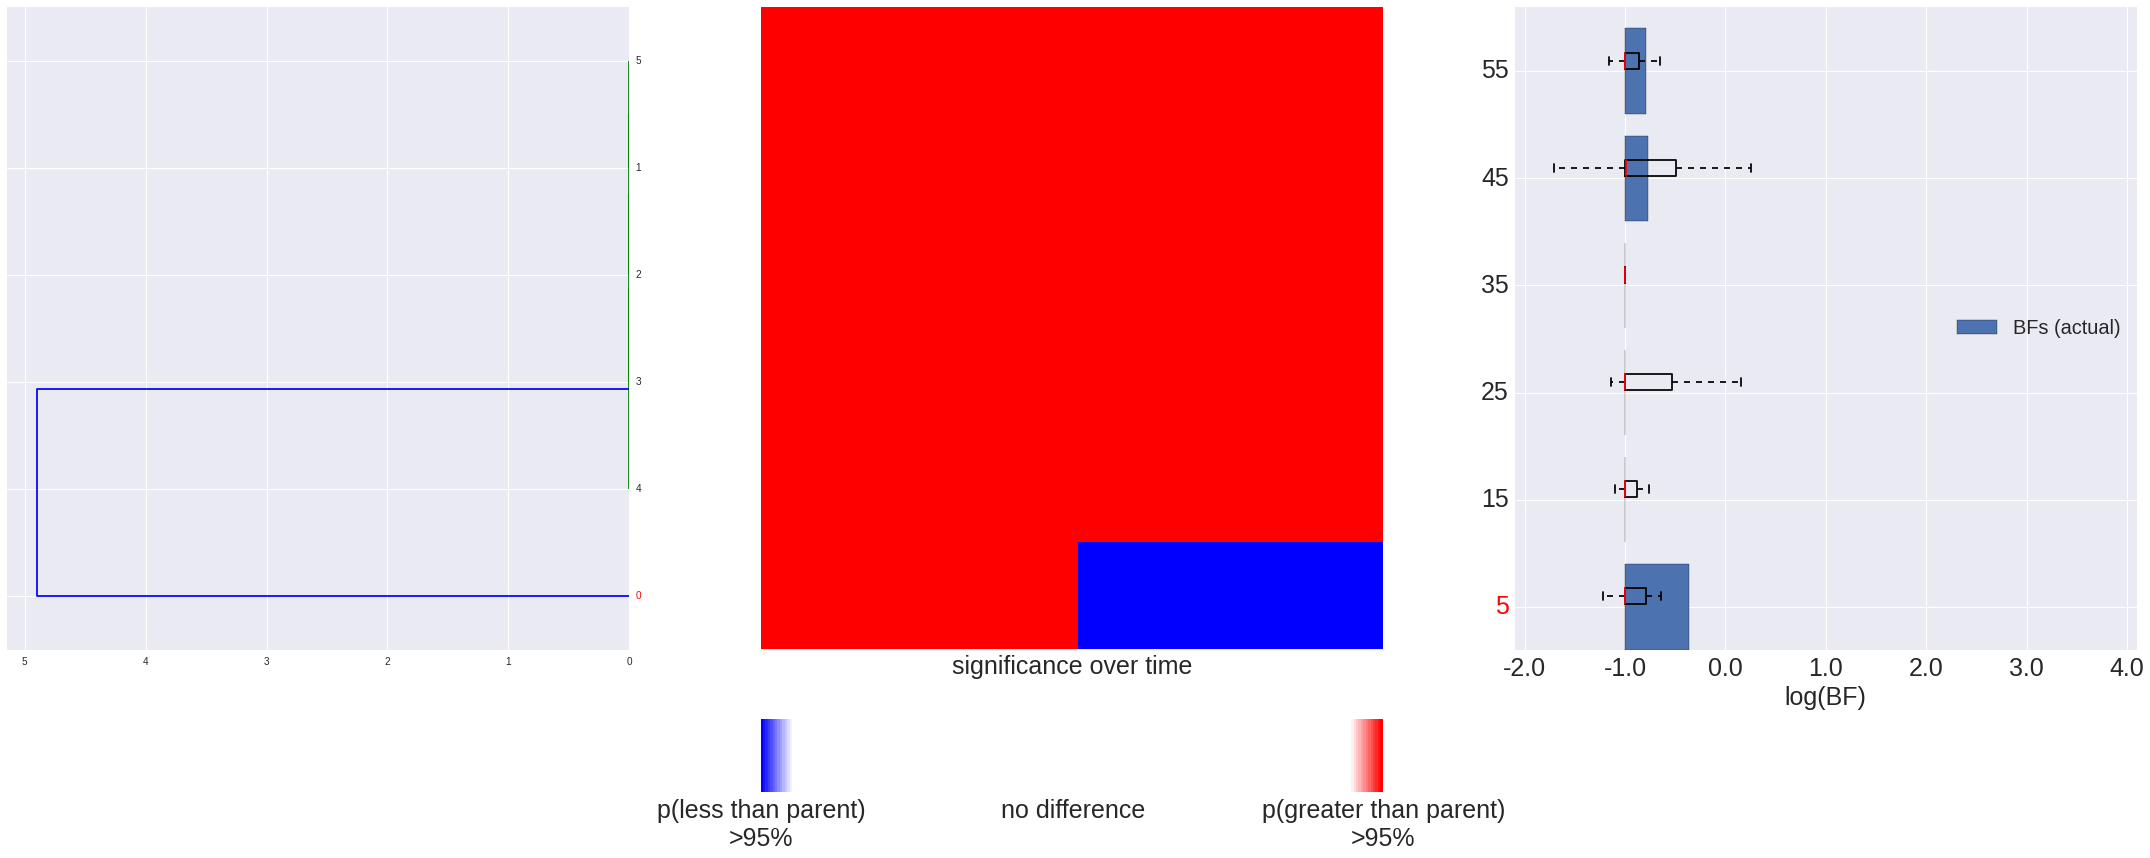

In [34]:
plt.figure(figsize=(30,12))
aspect = 10

ax1 = plt.subplot2grid((aspect+2,3), (0,0), colspan=1, rowspan=aspect)
ax2 = plt.subplot2grid((aspect+2,3), (0,1), colspan=1, rowspan=aspect)
ax4 = plt.subplot2grid((aspect+2,3), (0,2), colspan=1, rowspan=aspect)
cbarAx = plt.subplot2grid((aspect+2,3), (aspect,1), colspan=1, rowspan=2)

# plt.subplot(131)
z = scipy.cluster.hierarchy.linkage(thresh)
ret = scipy.cluster.hierarchy.dendrogram(z,orientation="right",ax=ax1);
yt = ax1.get_yticks()
ax1.set_yticks(yt)
# yl = ["$\Delta "+ l +'$' for l in labels.loc[ret['leaves'],"Strain"].tolist()]
# ax1.set_yticklabels(yl,fontsize=25)
# ax1.set_xticklabels(ax1.get_xticks().astype(str),fontsize=25)
# ax1.set_xlabel("distance (Euclidean)",fontsize=25,y=1.01)

# plt.subplot(132)
# im = ax2.imshow(1-conf[ret['leaves'],:],cmap=cmap,interpolation="none",aspect="auto",origin="top")
im = ax2.imshow(1-thresh[ret['leaves'],:],cmap=cmap,interpolation="none",aspect="auto",origin="top")
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("significance over time",fontsize=25)
# ax2.set_frame_on(True)

# cbar = plt.colorbar(im,ticks=[0,.5,1],orientation="horizontal",ax=cbarAx)
# cbar.ax.set_xticklabels(['less than parent', 'no difference', 'greater than parent'],fontsize=20)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbarAx, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',ticks=[0,.5,1])
cb1.ax.set_xticklabels(['p(less than parent)\n>95%', 'no difference', 'p(greater than parent)\n>95%'],fontsize=25)

ax4.barh(range(bfs.shape[0]),bfs[ret['leaves']],label="BFs (actual)")
ax4.legend(loc="center right",fontsize=20)

for h,i in enumerate(ret['leaves']):
    s,p = labels.iloc[i,:].values
    ax4.boxplot(bfsPermuted[(s,p)],vert=False,positions=[h+.5],boxprops={'color':'k'},whiskerprops={'color':'k'})

# ax4.text(3.65, 13, 'BFs (permuted)',
#             backgroundcolor='k',
#             color='white', weight='roman', size='xx-large')

    
ax4.set_ylim(0,bfs.shape[0])
ax4.set_yticks(np.arange(bfs.shape[0])+.4)
ax4.set_yticklabels(yt,fontsize=25)
ax4.set_xlabel("log(BF)",fontsize=25,y=1.01)
ax4.set_xticklabels(ax4.get_xticks().astype(str),fontsize=25)

ax4.set_xlim(-1.1,5.1)

# set significant labels to red
yl = ax4.get_yticklabels()
for i,t in enumerate(yl):
    s,p = labels.iloc[ret['leaves'][i],:].values
    if np.sum(bfs[ret['leaves'][i]] > bfsPermuted[(s,p)]) > bfsPermuted[(s,p)].shape[0]*.8:
        t.set_color('r')

yl = ax1.get_yticklabels()
for i,t in enumerate(yl):
    s,p = labels.iloc[ret['leaves'][i],:].values
#     if np.all(bfs[ret['leaves'][i]] > bfsPermuted[(s,p)]):
    if np.sum(bfs[ret['leaves'][i]] > bfsPermuted[(s,p)]) > bfsPermuted[(s,p)].shape[0]*.8:
        t.set_color('r')

plt.tight_layout()
plt.savefig("figures/funcDiff_paraquat.png",bbox_inches="tight",dpi=300)

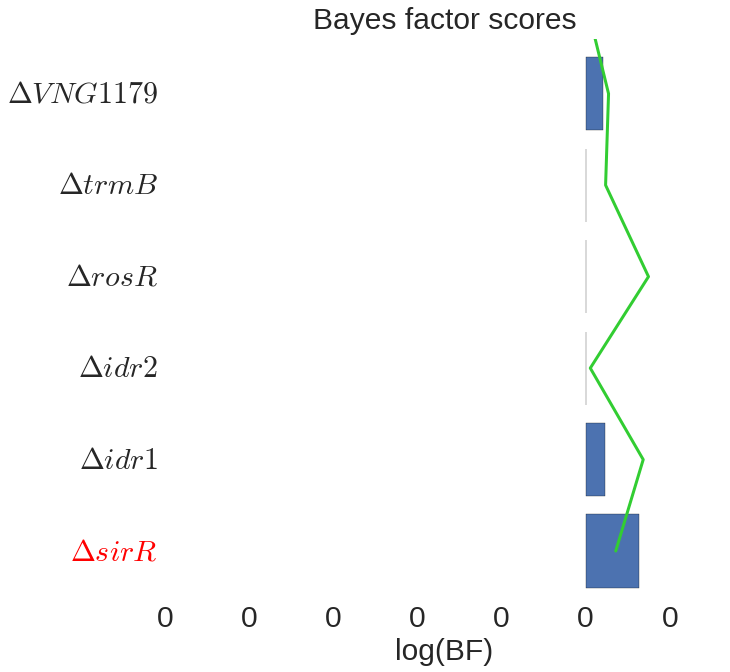

In [65]:
f,ax4 = plt.subplots(figsize=(10,10))

ax4.barh(table.index,table.BayesFactor,label="BFs (actual)")

keys = bfsPermuted.keys()

threshold = lambda x,alpha=.8: np.sort(x)[x.shape[0]*alpha]
thresholds = []

for i,r in table.iterrows():
    s,p = r.Strain,r.plate
    #ax4.boxplot(bfsPermuted[(s,p)],vert=False,positions=[i+.4],widths=[.6],boxprops={'color':'k','linewidth':3},whiskerprops={'color':'k','linewidth':5},capprops={'linewidth':3},medianprops={'linewidth':3})
    thresholds.append(threshold(bfsPermuted[(s,p)]))

yl = ["$\Delta "+ l +'$' for l in table.Strain]
ax4.set_yticks(np.arange(table.shape[0])+.4)
ax4.set_yticklabels(yl,fontsize=30)

yl = ax4.get_yticklabels()
for i,t in enumerate(yl):
    s,p = table.loc[i,['Strain','plate']]
    if np.sum(table.loc[i,'BayesFactor'] > bfsPermuted[(s,p)])>bfsPermuted[(s,p)].shape[0]*.8:
        t.set_color('r')

ax4.set_ylim(-.1,bfs.shape[0])
ax4.set_title("Bayes factor scores",fontsize=30,y=1.01)
ax4.set_xticklabels(ax4.get_xticks().astype(int).astype(str),fontsize=30)
ax4.set_xlabel("log(BF)",fontsize=30)
ax4.set_xlim(-5,bfs.max()+1)

plt.plot(thresholds,np.arange(len(thresholds))+.4,'limegreen',lw=3)

plt.savefig("figures/paraquat_bayesFactors.png",bbox_inches="tight",dpi=300)

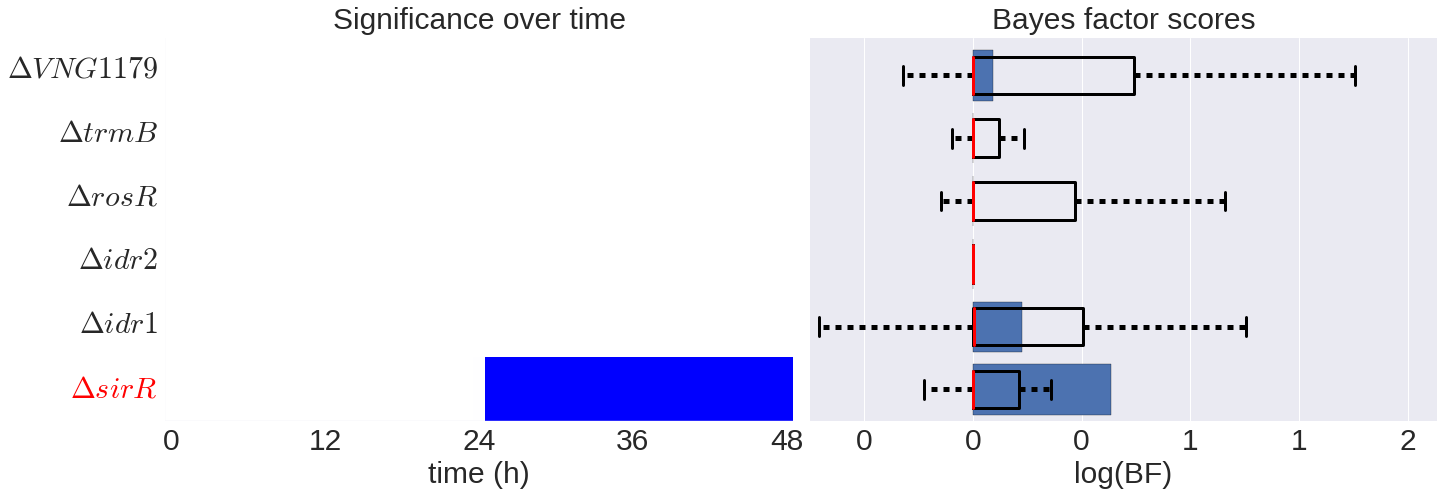

In [59]:
plt.figure(figsize=(20,6))
aspect = 50

# ax1 = plt.subplot2grid((aspect+1,3), (0,0), colspan=1, rowspan=aspect)
ax2 = plt.subplot2grid((aspect+1,2), (0,0), colspan=1, rowspan=aspect)
# ax3 = plt.subplot2grid((aspect+1,4), (0,2), colspan=1, rowspan=aspect)
ax4 = plt.subplot2grid((aspect+1,2), (0,1), colspan=1, rowspan=aspect)
# cbarAx = plt.subplot2grid((aspect+1,2), (aspect,0), colspan=1, rowspan=1)

im = ax2.imshow(-thresh,cmap=cmap,interpolation="none",aspect="auto",origin="top",vmin=-1,vmax=1)
ax2.grid(False)
t = np.linspace(0,48,5,dtype=int)
ax2.set_xticks(t)
ax2.set_xticklabels(ax2.get_xticks().astype(str),fontsize=30)
ax2.set_xlabel("time (h)",fontsize=30)
ax2.set_title("Significance over time",fontsize=30,y=1.01)
yl = ["$\Delta "+ l +'$' for l in strains]
ax2.set_yticks(range(6))
ax2.set_yticklabels(yl,fontsize=30)

norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbarAx, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',ticks=[0,.5,1])
cb1.ax.set_xticklabels(['p(less than parent)\n>95%', 'no difference', 'p(greater than parent)\n>95%'],fontsize=30)


ax4.barh(np.arange(bfs.shape[0]),bfs,label="BFs (actual)")


# for h,i in enumerate(ret['leaves']):
#     s,p = labels.iloc[i,:].values
for i,v in enumerate(zip(strains,plates)):
    s,p = v
    ax4.boxplot(bfsPermuted[(s,p)],vert=False,positions=[i+.4],widths=[.6],boxprops={'color':'k','linewidth':3},whiskerprops={'color':'k','linewidth':5},capprops={'linewidth':3},medianprops={'linewidth':3})
    

yl = ax2.get_yticklabels()
for i,t in enumerate(yl):
    s,p = zip(strains,plates)[i]
    if np.sum(bfs[i] > bfsPermuted[(s,p)])>bfsPermuted[(s,p)].shape[0]*.8:
        t.set_color('r')

# ax4.legend(loc="best",fontsize=25)

# ax4.text(292, 25, 'BFs (permuted)',
#             backgroundcolor='k',
#             color='white', weight='roman', size=25)

ax4.set_ylim(-.1,bfs.shape[0])
ax4.set_yticks([])
ax4.set_title("Bayes factor scores",fontsize=30,y=1.01)
ax4.set_xlabel("log(BF)",fontsize=30)
ax4.set_xlim(-.75,bfs.max()+1.5)
ax4.set_xticklabels(ax4.get_xticks().astype(int).astype(str),fontsize=30)

plt.tight_layout(pad=.5)
plt.savefig("figures/pq_testStatistic.png",bbox_inches="tight",dpi=150)

In [54]:
np.sum(bfs[0] > bfsPermuted[('sirR', u'20150630 PQ 5')])

84

In [53]:
bfsPermuted[('sirR', u'20150630 PQ 5')]

array([ -1.03545881e-06,  -4.41798989e-07,  -5.72029762e-07,
        -1.15528460e-01,   2.13686256e-01,  -1.71758870e-07,
        -6.87750912e-07,  -1.88685492e+00,   2.11833042e-01,
         1.03641887e+00,   6.69926475e-01,  -8.50714514e-07,
        -1.17066804e-06,   8.47244193e-02,   7.66045359e-01,
        -2.62564015e-06,   2.04537893e+00,  -2.56878889e-06,
        -3.91460629e-01,  -4.16015155e-07,  -2.37150903e-06,
         9.27872389e-01,   2.27459109e-03,   6.93509947e-01,
         2.54610135e+00,  -2.39762267e-06,  -8.54695713e-07,
         6.38135274e-02,   1.07090724e+00,   4.30133589e-05,
         1.86636090e+00,   2.28514854e-02,   3.34809899e-01,
         8.26677128e-01,  -6.66480219e-07,  -2.49958475e-07,
        -1.25727956e-06,   6.64805874e-01,  -1.75292871e-06,
        -3.85365809e-06,   2.61294554e-01,  -1.43144166e-06,
        -5.90763341e-06,  -1.29345722e-06,  -1.81475173e-06,
         1.92787342e+00,  -1.15210776e-06,  -1.65119752e-06,
        -3.98501811e-07,

In [60]:
columns = ["Strain",'plate','BayesFactor','FDR','PermutedValues']
table = pd.DataFrame(columns=columns)

for ind,tup in labels.iterrows():
    strain,plate = tup
    
    bf = bfs[ind]
    permBFs = bfsPermuted[(strain,plate)]
    fdr = 1.*np.sum(bfsPermuted[(strain,plate)] > bf)/bfsPermuted[(strain,plate)].shape[0]
    row = pd.DataFrame([[strain,plate,bf,fdr,permBFs.tolist()]],columns=columns)
    table = pd.concat((table,row))

AttributeError: 'list' object has no attribute 'iterrows'

In [232]:
table.to_csv("pq_bayesFactors.csv",index=False)